In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
x_mean=[]
x_std=[]

In [2]:
def stand(a):
    return (a-np.mean(a))/np.std(a),np.mean(a),np.std(a)

In [3]:
df = pd.read_csv('Bank_Personal_Loan_Modelling.csv')

for col in [1,2,3,5,7]:
    df.iloc[:, col] = pd.to_numeric(df.iloc[:, col], errors='coerce')


for col in [1,2,3,5,7]:
    a_col = df.iloc[:, col].values 
    sce, a1, b1 = stand(a_col)
    df.iloc[:, col] = sce 
    x_mean.append(a1)
    x_std.append(b1)

k = df.iloc[:, 1:].values.astype('float')

C:\Users\satya\AppData\Local\Temp\ipykernel_11696\803549947.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.77441684 -0.02952359 -0.55299157 ...  1.54088033  1.71536965
 -1.51268285]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, col] = sce
C:\Users\satya\AppData\Local\Temp\ipykernel_11696\803549947.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.66607847 -0.09633022 -0.44516316 ...  1.64783451  1.73504275
 -1.40445376]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, col] = sce
C:\Users\satya\AppData\Local\Temp\ipykernel_11696\803549947.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.53822878 -0.8641094  -1.36379301 ... -1.08136314 -0.5382287

In [4]:
print(k[2])

[-0.55299157 -0.44516316 -1.36379301  1.         -0.53673618  1.
 -0.55552393  0.          0.          0.          0.          0.        ]


In [5]:
from sklearn.impute  import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(k[:, 1:12])
k[:, 1:12] = imp.transform(k[:, 1:12])


In [6]:
x = k[:, :-1].astype('float')
y = k[:, -1].astype('float')
l=x.shape[0]
x_train=x[:int(0.6*l)]
x_val=x[int(0.6*l):int(0.8*l)]
x_test=x[int(0.8*l):]
y_train=y[:int(0.6*l):]
y_val = y[int(0.6*l):int(0.8*l)]
y_test=y[int(0.8*l):]
best_m=float('inf')
best_w=[]


In [7]:

def sf(z):
    return 1 / (1 + np.exp(-z))
def hf(w, x):
    return sf(x.dot(w)) >= 0.5  

def mse(h, y):
    ep = 1e-5  
    m1 = y.shape[0]
    return -(1 / m1) * (y.T.dot(np.log(h + ep)) + (1 - y).T.dot(np.log(1 - h + ep)))

def batch_gr(x, y,x_v,y_v ,epoch,l):
    m = np.shape(x)[0]
    x = np.c_[np.ones(m), x]  
    w = np.ones(np.shape(x)[1])  
    for i in range(epoch):
        h = sf(x.dot(w)) 
        e = h - y 
        gr = (1 / m) * (x.T.dot(e))  
        w -= l * gr
    x_v=np.c_[np.ones(x_v.shape[0]),x_v]  
    bb=sf(x_v.dot(w))
    val_mse=mse(bb,y_v)
    return w,val_mse

In [8]:
for epoch in [1000,5000,10000,100000]:
    for l in [0.01,0.05,0.001]:
        w,v_mse=batch_gr(x_train, y_train,x_val,y_val,epoch,l)
        if v_mse<best_m:
            best_m=v_mse
            best_w=w

x_t = np.c_[np.ones(x_test.shape[0]), x_test]  
h1 = sf(x_t.dot(best_w))  

print(mse(h1, y_test))


0.11348949122180997


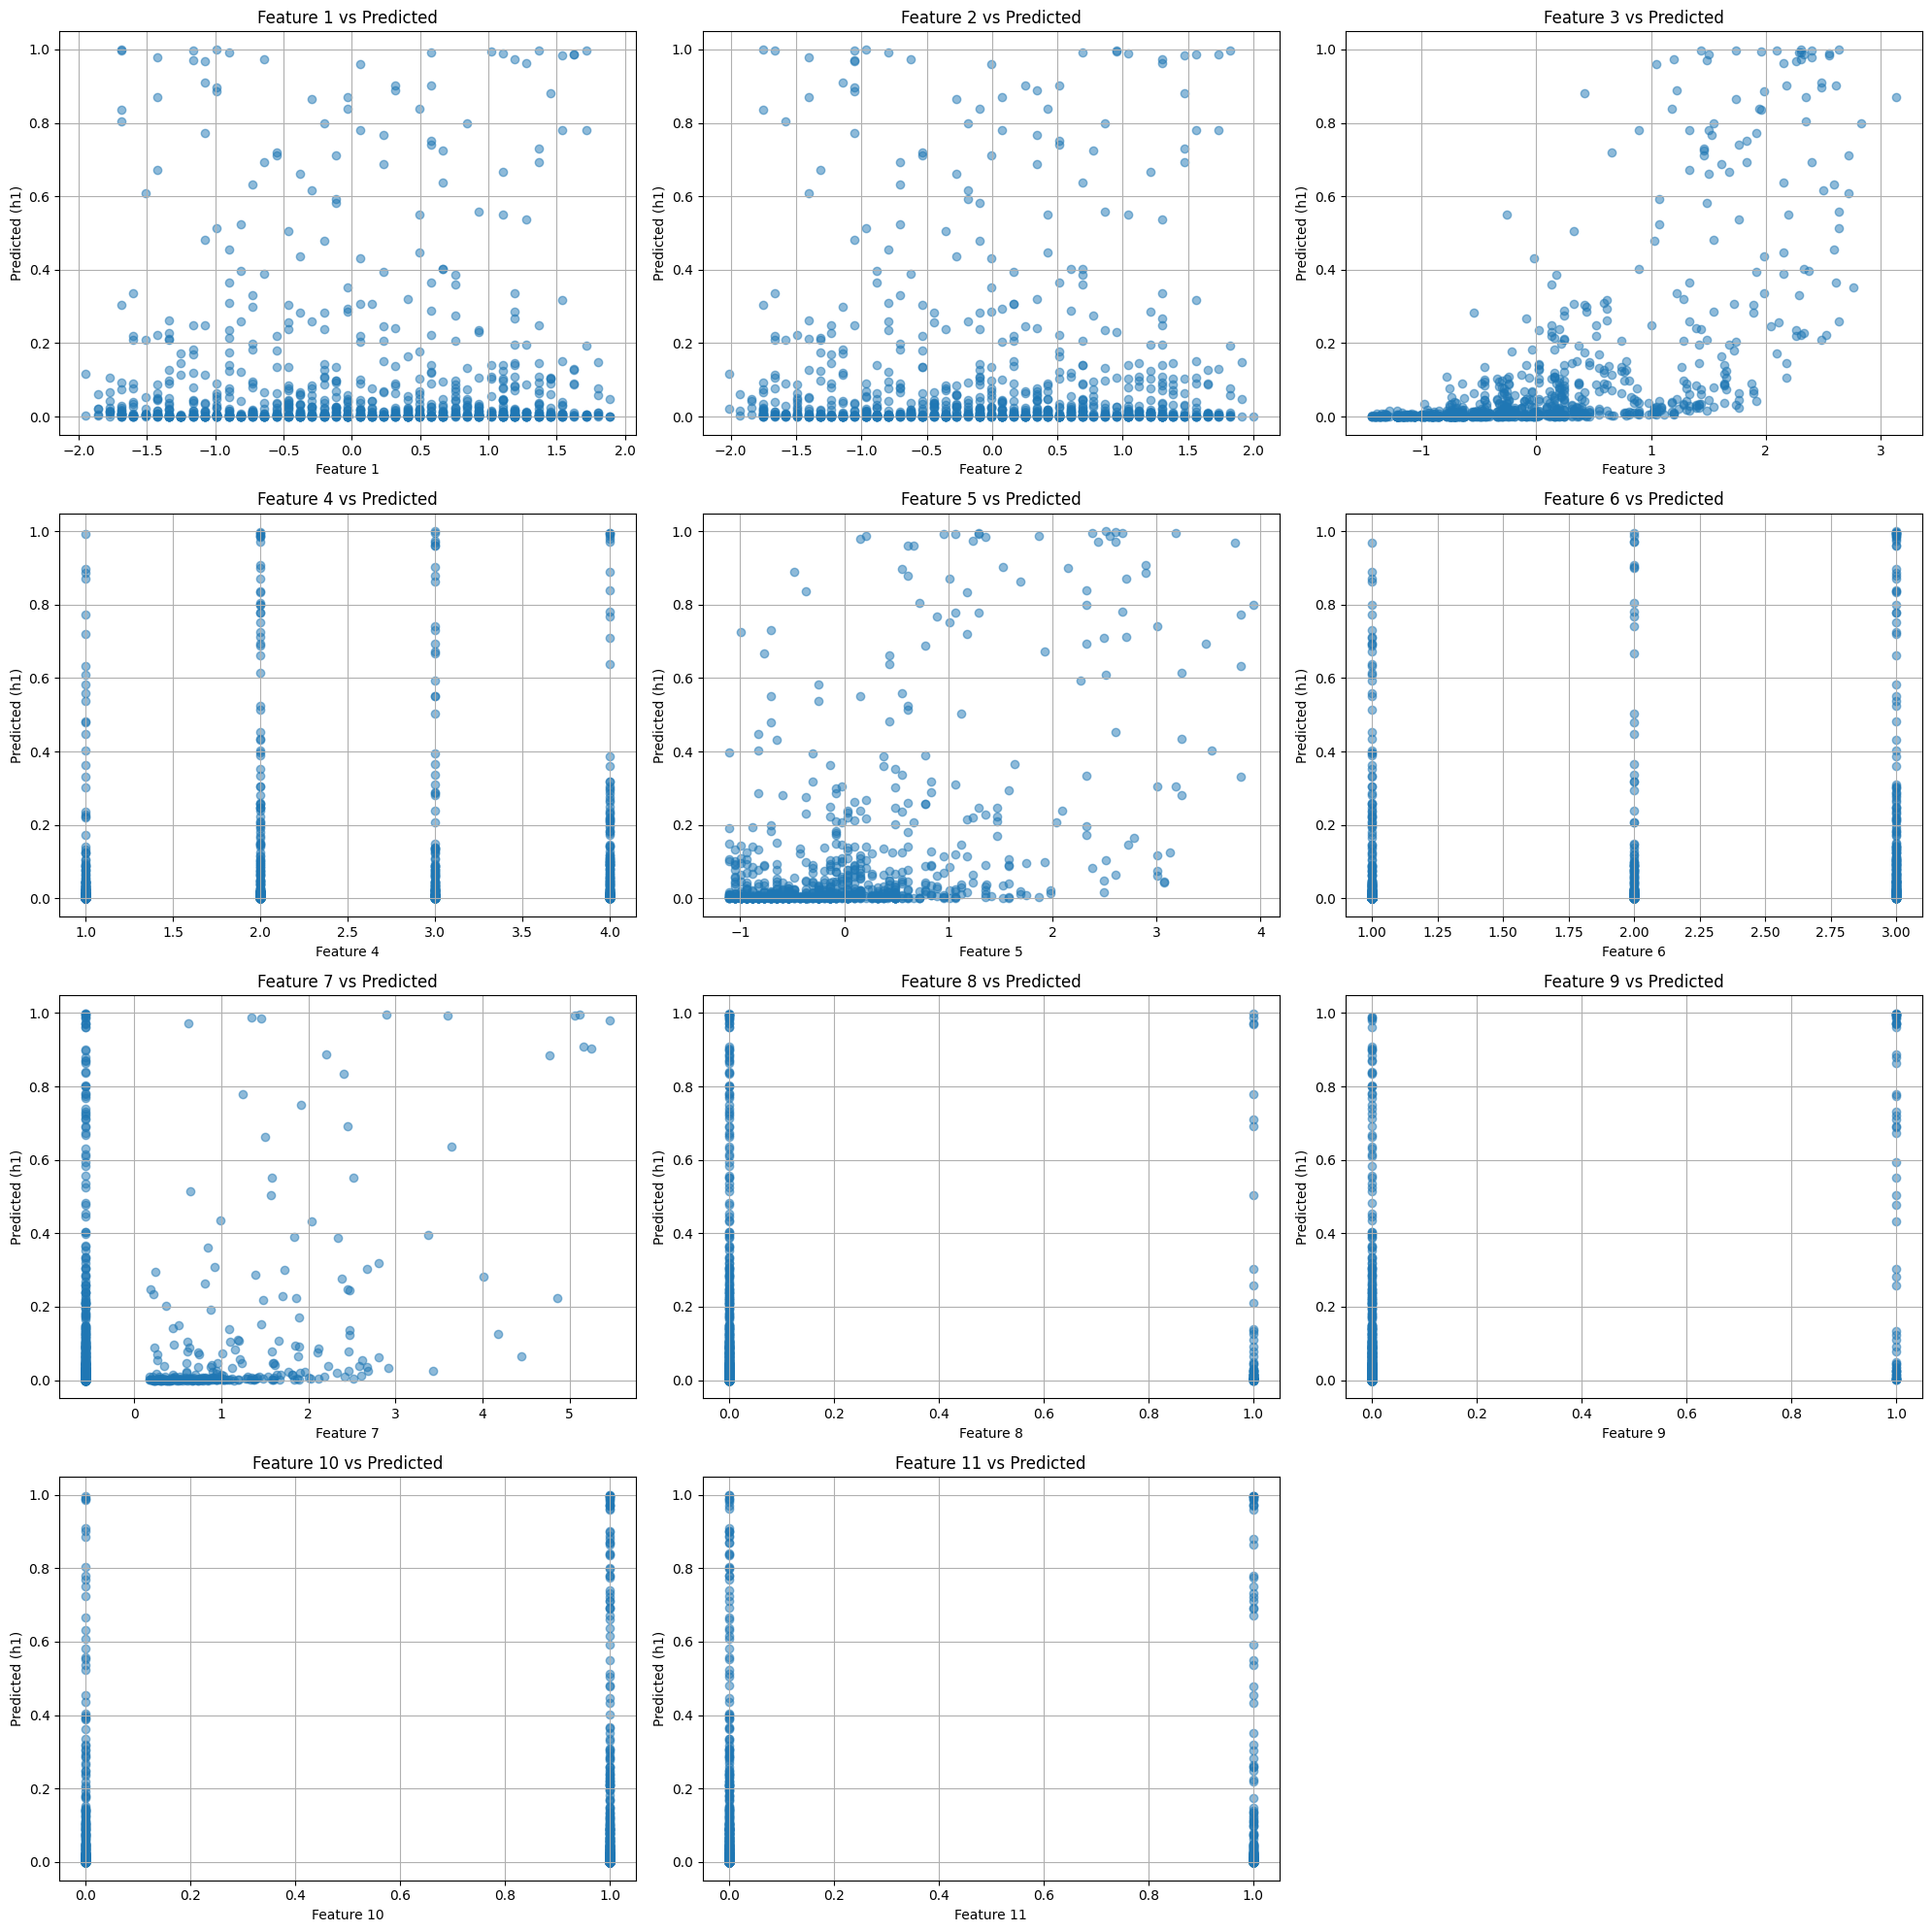

In [9]:

import math

num_features = x_test.shape[1] 

rows = math.ceil(num_features / 3)  
plt.figure(figsize=(20, rows * 5))  

for i in range(num_features):
    plt.subplot(rows, 3, i + 1)  
    plt.scatter(x_test[:, i], h1, alpha=0.5)
    plt.title(f"Feature {i+1} vs Predicted")
    plt.xlabel(f"Feature {i+1}")
    plt.ylabel("Predicted (h1)")
    plt.grid(True)

plt.tight_layout()  
plt.show()


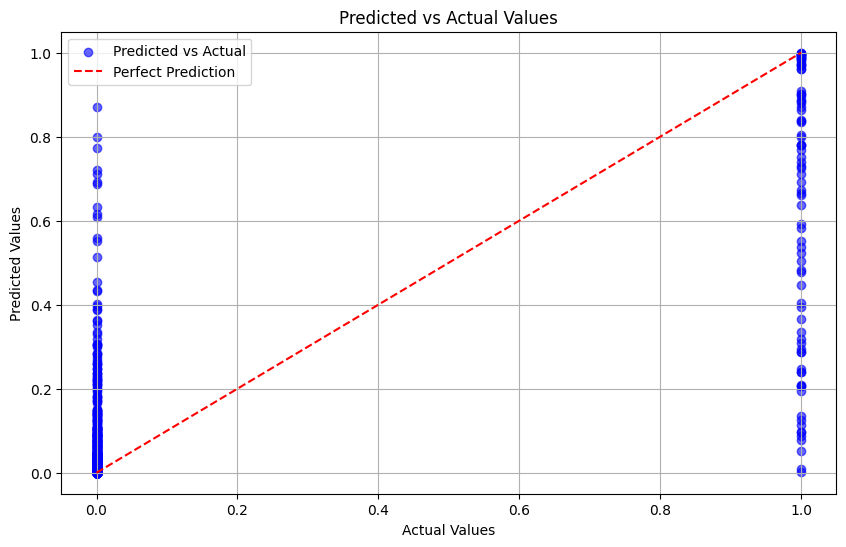

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, h1, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

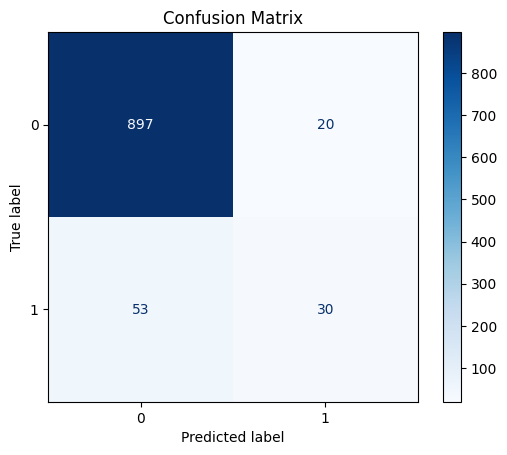

Accuracy: 0.927
Recall: 0.3614457831325301


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score

x_t = np.c_[np.ones(x_test.shape[0]), x_test] 
h1 = sf(x_t.dot(w))  

y_pred = (h1 >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")


Random Forest Test Accuracy: 0.987
Random Forest Recall: 0.8795180722891566
Best Random Forest Parameters: {'n_estimators': 50, 'max_depth': 10}
Random Forest outperforms Logistic Regression


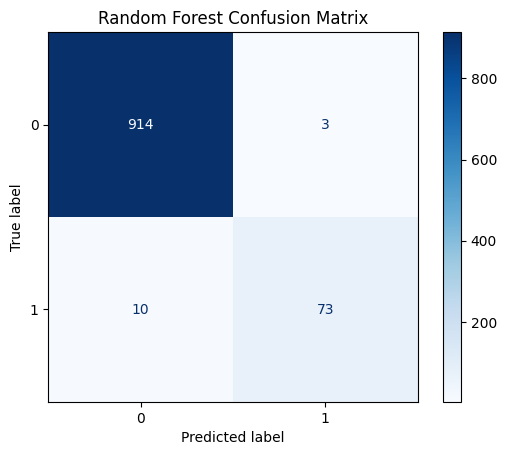

Logistic Regression Accuracy: 0.927
Random Forest Accuracy: 0.987


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score


best_rf_accuracy = 0
best_rf_params = None
best_rf_model = None


n_estimators_options = [50, 100, 200]
max_depth_options = [None, 10, 20]


for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_model.fit(x_train, y_train)

        
        y_rf_val_pred = rf_model.predict(x_val)
        rf_accuracy = accuracy_score(y_val, y_rf_val_pred)

        
        if rf_accuracy > best_rf_accuracy:
            best_rf_accuracy = rf_accuracy
            best_rf_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
            best_rf_model = rf_model


y_rf_test_pred = best_rf_model.predict(x_test)
rf_test_accuracy = accuracy_score(y_test, y_rf_test_pred)
rf_recall = recall_score(y_test, y_rf_test_pred)


print(f"Random Forest Test Accuracy: {rf_test_accuracy}")
print(f"Random Forest Recall: {rf_recall}")
print(f"Best Random Forest Parameters: {best_rf_params}")


if rf_test_accuracy > accuracy:
    print("Random Forest outperforms Logistic Regression")
    best_w = best_rf_model
else:
    print("Logistic Regression outperforms Random Forest")
    best_w = best_w  


rf_cm = confusion_matrix(y_test, y_rf_test_pred)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
rf_disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()


print(f"Logistic Regression Accuracy: {accuracy}")
print(f"Random Forest Accuracy: {rf_test_accuracy}")


In [13]:
xam=[34,9,180,1,8.9,3,0,0,0,0,0]
for i in range(len(xam)):
    if i==0:
        xam[i]=xam[i]=(xam[i]-x_mean[0])/x_std[0]
    if i==1:
        xam[i]=xam[i]=(xam[i]-x_mean[1])/x_std[1]
    if i==2:
        xam[i]=xam[i]=(xam[i]-x_mean[2])/x_std[2]
    if  i==4:
        xam[i]=xam[i]=(xam[i]-x_mean[3])/x_std[3]
    if i==6:
        xam[i]=xam[i]=(xam[i]-x_mean[4])/x_std[4]
if rf_test_accuracy < accuracy:
    xam=np.array(xam).reshape(-1,1).astype('float')
    xam=xam.T
    xam=np.c_[np.ones(xam.shape[0]),xam]
    print(hf(best_w,xam))
else:
    xam_array = np.array(xam).reshape(1, -1)

    rf_prediction = best_rf_model.predict(xam_array)

    print("True") if rf_prediction[0]==1 else print("False")


True


In [14]:
import pickle
if rf_test_accuracy < accuracy:
    xam=np.array(xam,dtype=float).reshape(-1,1)
    print(hf(best_w,xam.T))
    with open('C:\\Users\\satya\\OneDrive\\Documents\\ml_project\\website\\models\\personal_loan.pkl', 'wb') as f:
        pickle.dump(best_w, f)
   
else:
    xam_array = np.array(xam).reshape(1, -1)

    rf_prediction = best_rf_model.predict(xam_array)

    print("True") if rf_prediction[0]==1 else print("False")
    with open('C:\\Users\\satya\\OneDrive\\Documents\\ml_project\\website\\models\\personal_loan.pkl', 'wb') as f:
        pickle.dump(best_rf_model, f)
scaling_params = {'x_mean': x_mean, 'x_std': x_std}
with open('C:\\Users\\satya\\OneDrive\\Documents\\ml_project\\website\\models\\scaling_params_personal.pkl', 'wb') as f:
    pickle.dump(scaling_params, f)

True
